# Part 5: eSTRs are potential drivers of published GWAS signals - RFT1 analysis

This notebook contains:

#### Figures:
* **Figure 6B**: RFT1 expression summary stats
* **Figure 6B**: RFT1 GWAS summary stats
* **Figure 6D**: Manhattan plot of eMerge vs. Yengo
* **Figure 6E**: RFT1 vs. height
* **Figure 6F**: Odds ratio vs. repeat number
* **Figure 6G**: Reporter assay results

Note, **Figure 6A** of STRs vs. expression is in the ExampleESTRs notebook

#### Supplementary Figures:


In [2]:
# Set up
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
from sklearn.cluster import KMeans

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-GWAS"
FIGPREFIX = "Figure6"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

############ Load data #############
emerge_snp_assoc = pd.read_csv("/storage/mgymrek/eMERGE/snp_assoc/chr3.assoc.linear", delim_whitespace=True)
emerge_snp_assoc["POS"] = emerge_snp_assoc["BP"]
yengo_snp = pd.read_csv("/storage/mgymrek/eMERGE/height_ukb_chr3.tab", delim_whitespace=True)
strassoc = pd.read_csv("/storage/mgymrek/eMERGE/test_str_assoc/RFT1.tab", sep="\t", comment="#")
dmatrix = pd.read_csv("/storage/mgymrek/eMERGE/test_str_assoc/RFT1.dmatrix.tab", sep="\t")

Populating the interactive namespace from numpy and matplotlib


/home/mgymrek/.local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/mgymrek/.local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/mgymrek/.local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/mgymrek/.local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/mgymrek/.local/lib/python2.7/site-packages/pandas/core/indexes/base.py:7: Runtime

# Figure 6D: Manhattan plot for eMERGE/Yengo

In [22]:
strassoc
ss_rft1[ss_rft1["POS"]==lead_yengo]

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P_x,POS,P_y
63,3,3:53134098:T:C,53134098,T,ADD,11587,0.04104,3.037,0.002396,53134098,1.500000e-97


lead SNP yengo: 53134098 1.4999999999999996e-97 0.002396
str pval 0.00328


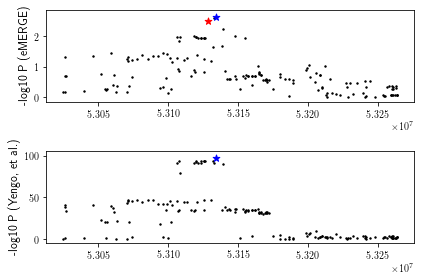

In [3]:

# Load SNP
summstats = pd.merge(emerge_snp_assoc, yengo_snp, on=["POS"])
ss_rft1 = summstats[(summstats["BP"]>53022501) & (summstats["BP"]<53264470)]
lead_yengo = ss_rft1.sort_values("P_y")["POS"].values[0]
lead_snp = ss_rft1[ss_rft1["POS"]==lead_yengo]
print("lead SNP yengo: %s %s %s"%(lead_snp["BP"].values[0], lead_snp["P_y"].values[0], lead_snp["P_x"].values[0]))

# Load STR
strpos = strassoc["start"].values[0]
strp = strassoc[strassoc["type"].apply(lambda x: "STR_" in x)]["p-val"].values[0]
print("str pval %s"%strp)
msize = 50
mval = "*"
fig = plt.figure()
ax = fig.add_subplot(211)
ax.scatter(ss_rft1["BP"], ss_rft1["P_x"].apply(lambda x: -1*np.log10(x)), s=2, color="black")
ax.scatter(lead_snp["BP"], lead_snp["P_x"].apply(lambda x: -1*np.log10(x)), s=msize, color="blue", marker=mval)
ax.scatter([strpos], [-1*np.log10(strp)], s=msize, color="red", marker=mval)

ax.set_ylabel("-log10 P (eMERGE)", size=12)

ax = fig.add_subplot(212)
ax.scatter(ss_rft1["BP"], ss_rft1["P_y"].apply(lambda x: -1*np.log10(x)), s=2, color="black")
ax.scatter(lead_snp["BP"], lead_snp["P_y"].apply(lambda x: -1*np.log10(x)), s=msize, color="blue", marker=mval)
ax.set_ylabel("-log10 P (Yengo, et al.)", size=12)

fig.tight_layout()
fig.savefig(os.path.join(RESULTSDIR, "%s_RFT1_Manhattan_eMERGE.pdf"%FIGPREFIX))

# Figure 6E: rpt. num vs. height

/home/mgymrek/.local/lib/python2.7/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,var,num,median,mean,GT
GT,,,,,
82,1.016427,2331.0,-0.023527,-0.028960,82
86,0.861985,935.0,-0.005934,-0.013238,86
88,0.990602,1922.0,0.025828,0.020825,88
90,0.990028,385.0,0.091516,0.061342,90
92,1.136300,362.0,0.020747,0.050369,92
94,1.125650,458.0,0.128491,0.097124,94


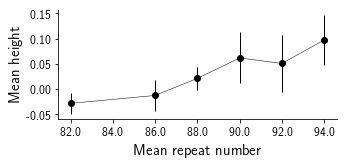

In [4]:
dd = dmatrix.groupby("GT", as_index=True).agg({"phenotype": {"mean": np.mean, "median": np.median, "num": len, "var": np.var}})
dd.columns = dd.columns.get_level_values(1)
dd["GT"] = dd.index

cutoff = 100
ddx = dd[dd["num"]>=cutoff]
ddy = dd[dd["num"]<cutoff]

fig = plt.figure()
fig.set_size_inches((5, 2))
ax = fig.add_subplot(111)
ax.errorbar(ddx["GT"], ddx["mean"], ddx.apply(lambda x: np.sqrt(x["var"]/x["num"]), 1),
            linewidth=0.5, elinewidth=1, marker="o", color="black")
#ax.errorbar(ddy["GT"], ddy["mean"], ddy.apply(lambda x: np.sqrt(x["var"]/x["num"]), 1),
#            linewidth=0, elinewidth=1, marker="o", color="gray")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Mean repeat number", size=15)
ax.set_ylabel("Mean height", size=15)
#ax.set_ylim(bottom=-0.1, top=0.3)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(["%.2f"%item for item in ax.get_yticks()], size=12)
fig.savefig(os.path.join(RESULTSDIR, "%s_RFT1_rpt_vs_height_eMERGE.pdf"%FIGPREFIX))
dd

# Figure 6F: Reporter assay

In [5]:
# Extract RFT1 expression data
def ExtractData(gene, chrom, start, tissue):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)
    
ExtractData("ENSG00000163933.5", "chr3", 53128363, "Artery-Aorta")
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
expr = pd.read_csv("expr.tab", names=["sample","expr"])
data = pd.merge(strgt, expr)

In [6]:
dd = data.groupby("str", as_index=False).agg({"expr": {"meanexpr": np.mean, "sdexpr": lambda x: np.sqrt(np.var(x)), "num": len}})
dd.columns = ["str"]+dd.columns.get_level_values(1)
dd["gt"] = (dd["str"]/2+17).apply(int) # 17 repeats in ref genome, dinuc
dd = dd[dd["gt"]<=12]
dd

,str,strsdexpr,strnum,strmeanexpr,gt
0,-22,0.161401,3.0,-0.708670,6
1,-20,0.423627,45.0,-0.445960,7
2,-18,0.605383,5.0,-0.335722,8
3,-16,0.466064,21.0,-0.079692,9
4,-14,0.401582,47.0,-0.014856,10
5,-12,0.454164,13.0,0.491939,11
6,-10,0.420481,15.0,0.616569,12


(0.9869189501477705, 0.013081049852229467)
T-test from empty 0 0.0005824254659593021
T-test from empty 5 4.8020631947413606e-05
T-test from empty 10 7.64453692892305e-05
T-test from empty 12 0.0006756374614528605
T-test for 0 vs. 5: 0.002811099751376361
T-test for 5 vs. 10: 0.005329552749096339
T-test for 10 vs. 12: 0.09385068008190199


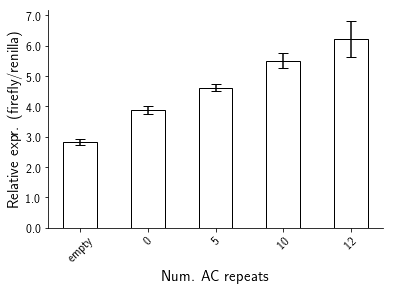

In [17]:
rft1_vals = [
    [3.707497693,4.065673655,3.864511626],
    [4.78773303,4.501644861,4.555870539],
    [5.688627718,5.688627718,5.155467566],
    [5.418876832,6.46927529,6.820951242]
]
dhrs1_vals = [
    [2.967732864,2.768968656,2.7077137],
    [5.596787029,5.859725523,5.685063759],
    [3.5948938,3.376481434,3.467178298]
]
htatip2_vals = [
    [5.359804961,5.767828635,5.542973847],
    [6.733610309,7.115738947,7.86978226],
    [6.836058963,8.36171054,6.795353056]
]
empty_vals = [2.694100558,2.903661361,2.913570639]

rft1_means = [np.mean(item) for item in rft1_vals]
rft1_sds = [np.sqrt(np.var(item)) for item in rft1_vals]
rft1_labels = [0,5,10,12]

empty_mean = np.mean(empty_vals)
empty_sd = np.sqrt(np.var(empty_vals))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(0, len(rft1_labels)+1), [empty_mean]+rft1_means, yerr=[empty_sd]+rft1_sds,
      color="white", edgecolor="black", width=0.5, capsize=5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Num. AC repeats", size=15)
ax.set_ylabel("Relative expr. (firefly/renilla)", size=15);

ax.set_xticks(range(0, len(rft1_labels)+1))
ax.set_xticklabels([(item) for item in ["empty"]+rft1_labels], size=12, rotation=45)
ax.set_yticklabels(["%.1f"%item for item in ax.get_yticks()], size=12);

fig.savefig(os.path.join(RESULTSDIR, "%s_RFT1_reporter.pdf"%FIGPREFIX))

# Stats
print(scipy.stats.pearsonr(rft1_labels, rft1_means))

# Each val vs. empty (1-sided)
for i in range(len(rft1_vals)):
    item = rft1_vals[i]
    allele = rft1_labels[i]
    print("T-test from empty %s %s"%(allele, scipy.stats.ttest_ind(empty_vals,item)[1]/2))

# Each val vs. next lowest (1-sided)
for i in range(1, len(rft1_vals)):
    print("T-test for %s vs. %s: %s"%(rft1_labels[i-1], rft1_labels[i], scipy.stats.ttest_ind(rft1_vals[i], rft1_vals[i-1])[1]/2))

In [8]:
RESULTSDIR

'/storage/mgymrek/gtex-estrs-paper/results/eSTR-GWAS'